# Memory Collection Schema
Sometimes we want to save memories to a [collection](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200) rather than single profile. 

We'll also show how to use [Trustcall](https://github.com/hinthornw/trustcall) to update this collection. 


In [99]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [100]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

In [101]:
_set_env("OPENAI_API_KEY")

## Defining a collection schema

Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

We can define a collection schema as a [Pydantic](https://docs.pydantic.dev/latest/) object.

In [102]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

### Structured output
We can used LangChain's chat model [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface's [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

In [103]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Lance. I like to bike.")]) # Q: How it works?
memory_collection.memories

[Memory(content="User's name is Lance."),
 Memory(content='User likes to bike.')]

We can use `model_dump()` to serialize a Pydantic model instance into a Python dictionary.

In [104]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Lance."}

## Updating collection schema

We want to *update existing memories* with *new memories* in the collection.
Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection.
This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

In [105]:
from trustcall import create_extractor

# Create the extractor which will parse structured output from model to object
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True, # to allow the extractor to insert new memories to the collection
)

In [106]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [107]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_Hh02B7oiKQs3nidz1boewy7B)
 Call ID: call_Hh02B7oiKQs3nidz1boewy7B
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [108]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [109]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_Hh02B7oiKQs3nidz1boewy7B'}


In [110]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [111]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [112]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_24K4Wl3z3Hc78kPG4WOywdJG)
 Call ID: call_24K4Wl3z3Hc78kPG4WOywdJG
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.
    -: User was thinking about Japan and going back this winter.
  Memory (call_byQou4VdqPrZLz2tVwz5Cyfz)
 Call ID: call_byQou4VdqPrZLz2tVwz5Cyfz
  Args:
    content: User went to Tartine and ate a croissant.
  Memory (call_bnvxr8LhcjGKex6E3G2f9ttQ)
 Call ID: call_bnvxr8LhcjGKex6E3G2f9ttQ
  Args:
    content: User was thinking about Japan and going back this winter.


In [113]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'
content='User went to Tartine and ate a croissant.'
content='User was thinking about Japan and going back this winter.'


In [114]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_24K4Wl3z3Hc78kPG4WOywdJG', 'json_doc_id': '0'}
{'id': 'call_byQou4VdqPrZLz2tVwz5Cyfz'}
{'id': 'call_bnvxr8LhcjGKex6E3G2f9ttQ'}


### In memory key-value store
Save dictionary representation of each memory to the store.

In [115]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store where we will store memories
in_memory_store = InMemoryStore() # Q: What is the good replacement for InMemoryStore?

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories") # Q: Why we need namespace?

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

# Q: If I reload notebook this storage will stay?

Search for memories in the store.

In [116]:
# Search
for m in in_memory_store.search(namespace_for_memory): # Q: What are the possible arguments for search?
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '544ba667-ad23-47bc-8928-148c1771754f', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-03-23T20:31:09.037052+00:00', 'updated_at': '2025-03-23T20:31:09.037053+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '1a2fdba5-c052-45de-8d10-4ee2691e3cff', 'value': {'content': 'User likes to bike.'}, 'created_at': '2025-03-23T20:31:09.037116+00:00', 'updated_at': '2025-03-23T20:31:09.037117+00:00', 'score': None}


In [117]:
from langchain.embeddings import init_embeddings

in_memory_embed_store = InMemoryStore(index={
    "dims": 1536,
    "embed": init_embeddings("openai:text-embedding-3-small"),
    "fields": ["text"],
})

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = {"text": memory_collection.memories[0].content}
in_memory_embed_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = {"text": memory_collection.memories[1].content}
in_memory_embed_store.put(namespace_for_memory, key, value)

In [118]:
for m in in_memory_embed_store.search(namespace_for_memory, query="Lance"):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '8faa1d20-c98b-4e01-9c37-8af6d66c43a4', 'value': {'text': "User's name is Lance."}, 'created_at': '2025-03-23T20:31:13.440318+00:00', 'updated_at': '2025-03-23T20:31:13.440331+00:00', 'score': 0.7283749541421611}
{'namespace': ['1', 'memories'], 'key': '813556b3-4e9f-4083-9a29-3da2e556ca02', 'value': {'text': 'User likes to bike.'}, 'created_at': '2025-03-23T20:31:13.748853+00:00', 'updated_at': '2025-03-23T20:31:13.748870+00:00', 'score': 0.2700927546801956}


## Graph with memory collection

In [119]:
# Initialize the model
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [120]:
trustcall_extractor = create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True, # This allows the extractor to insert new memories
)

In [129]:
from langchain_core.messages import merge_message_runs
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

MODEL_SYSTEM_MESSAGE = """
You are a helpful chatbot. You are designed to be a companion to a user.
You have a long term memory which keeps track of information you learn about the user over time.
Current Memory (may include updated memories from this conversation):
{memory}
"""

TRUSTCALL_INSTRUCTION = """
Reflect on following interaction.
Use the provided tools to retain any necessary memories about the user.
Use parallel tool calling to handle updates and insertions simultaneously:
"""

# Node
def call_llm(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    response = llm.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

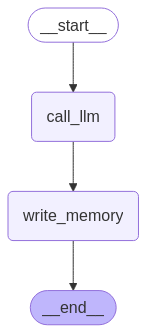

In [130]:
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [131]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

result = graph.invoke({"messages": input_messages}, config)
# Run the graph
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I assist you today?


In [132]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco has some beautiful routes for biking. Do you have a favorite trail or area you like to explore?


In [133]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '26260a0b-99b1-492b-852d-64dc95785236', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-03-23T20:32:47.950864+00:00', 'updated_at': '2025-03-23T20:32:47.950865+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '694e6126-08be-429b-933f-da806ddda196', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-03-23T20:32:47.950839+00:00', 'updated_at': '2025-03-23T20:32:47.950841+00:00', 'score': None}


In [134]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and bakeries make a great combination! Do you have a favorite bakery in San Francisco, or are you still exploring different ones?


Continue the conversation in a new thread.

In [135]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy biking around San Francisco, you might want to check out some of these bakeries that are perfect for a bike ride stop:

1. **Tartine Bakery** - Located in the Mission District, it's famous for its bread and pastries. It's a great spot to refuel after a ride.

2. **Arsicault Bakery** - Known for its incredible croissants, this bakery in the Richmond District is a must-visit.

3. **B. Patisserie** - Situated in Lower Pacific Heights, it offers a delightful selection of pastries and is a nice spot to relax.

4. **Mr. Holmes Bakehouse** - In the Tenderloin, this bakery is famous for its cruffins and other creative pastries.

5. **Noe Valley Bakery** - A cozy spot in Noe Valley, perfect for a quick stop during your biking adventures.

Do any of these sound like a good fit for

In [136]:
# Q: Why we need both in-thread and in-memory storage? What is the difference?

## Task
Modify the graph to add only the most relevant memory according to the last message